# Converting efficientdet from Tensorflow to ONNX

Google recently [published the new object detection model efficientdet](
https://github.com/google/automl/tree/master/efficientdet) that show excellent performance and accuracy. The models are found [here](https://github.com/google/automl/tree/master/efficientdet). 
This tutorial shows how to convert them to ONNX.

To start, we setup a few environment variables and download the pre-trained model.

In [2]:
import os

HOME = os.getcwd()
MODEL = "efficientdet-d2"
os.environ['PYTHONPATH'] = os.path.join(HOME, "tpu")
os.environ['MODEL'] = MODEL
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [ ]:
%cd {HOME}
!git clone https://github.com/google/automl

In [4]:
%cd {HOME}/automl/efficientdet

/gs/automl/efficientdet


In [ ]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/$MODEL.tar.gz
!tar zxf $MODEL.tar.gz

Read the checkpoint and export a frozen graph:

In [ ]:
import os
import time

from absl import flags
import numpy as np
import tensorflow.compat.v1 as tf
from typing import Text, Tuple, List

import efficientdet_arch
import retinanet_arch
import utils
import model_inspect


FLAGS = model_inspect.flags.FLAGS
FLAGS.input_image_size = 768

def main(_):
    if tf.io.gfile.exists(FLAGS.logdir) and FLAGS.delete_logdir:
        tf.logging.info('Deleting log dir ...')
        tf.io.gfile.rmtree(FLAGS.logdir)

    inspector = model_inspect.ModelInspector(
      model_name=MODEL,
      image_size=FLAGS.input_image_size,
      num_classes=FLAGS.num_classes,
      logdir=FLAGS.logdir,
      tensorrt=False,
      use_xla=False,
      ckpt_path=MODEL,
      enable_ema=FLAGS.enable_ema,
      export_ckpt=os.path.join("/tmp", MODEL))

    inspector.build_and_save_model()
    graph_def = inspector.freeze_model()
    tf.compat.v1.reset_default_graph()
    with tf.compat.v1.Session() as sess:
        tf.import_graph_def(graph_def, name='')
        with tf.io.gfile.GFile(MODEL + ".pb", 'wb') as f:
            f.write(sess.graph_def.SerializeToString())

tf.app.run(main)


Install and run tf2onnx directly on the graphdef:

In [4]:
!pip install git+https://github.com/onnx/tensorflow-onnx
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-0n0hx589
  Running command git clone -q https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-0n0hx589
  Created wheel for tf2onnx: filename=tf2onnx-1.6.0-py3-none-any.whl size=166950 sha256=de784f7160cad79f2b239dc0c5ed2e963a522f71b5c243a6f9b2560f779d768f
  Stored in directory: /tmp/pip-ephem-wheel-cache-it0qw4y_/wheels/73/99/8e/3034c9b47124da4ac24a6ea72b8da1be5af878e37c2e953bb3
Successfully built tf2onnx
Defaulting to user installation because normal site-packages is not writeable


In [7]:
!python -m tf2onnx.convert --opset 11 --fold_const --input $MODEL.pb --output $MODEL.onnx \
    --inputs input:0 \
    --outputs class_net/class-predict/BiasAdd:0,class_net/class-predict_1/BiasAdd:0,class_net/class-predict_2/BiasAdd:0,class_net/class-predict_3/BiasAdd:0,class_net/class-predict_4/BiasAdd:0,box_net/box-predict/BiasAdd:0,box_net/box-predict_1/BiasAdd:0,box_net/box-predict_2/BiasAdd:0,box_net/box-predict_3/BiasAdd:0,box_net/box-predict_4/BiasAdd:0 


2020-03-19 16:10:06.366648: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-19 16:10:06.366741: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-19 16:10:06.366768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
2020-03-19 16:10:08,128 - WARNING - From /gs/.local/lib/python3.7

In [8]:
!wget -q http://images.cocodataset.org/val2017/000000088462.jpg

Now that we have the ONNX model we can write a quick demo using onnxruntime:

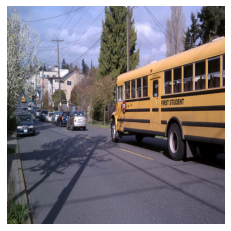

In [54]:
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
import matplotlib.pyplot as plt

H = 768
W = 768
img = Image.open("000000088462.jpg")
img = img.resize((H, W), Image.BILINEAR)
plt.axis('off')
plt.imshow(img)
plt.show()

In [55]:
feed = {"input:0": np.expand_dims(np.asarray(img, dtype='float32'), axis=0)}
outputs = ["class_net/class-predict/BiasAdd:0", "class_net/class-predict_1/BiasAdd:0",
           "class_net/class-predict_2/BiasAdd:0", "class_net/class-predict_3/BiasAdd:0", 
           "class_net/class-predict_4/BiasAdd:0", "box_net/box-predict/BiasAdd:0",
           "box_net/box-predict_1/BiasAdd:0", "box_net/box-predict_2/BiasAdd:0", 
           "box_net/box-predict_3/BiasAdd:0", "box_net/box-predict_4/BiasAdd:0"]

In [56]:
import onnxruntime as rt
sess = rt.InferenceSession(MODEL + ".onnx")

In [57]:
results = sess.run(outputs, feed)
r = results[5]

In [58]:
for i, name in enumerate(outputs):
    print(i, name, results[i].shape, results[i].dtype)

0 class_net/class-predict/BiasAdd:0 (1, 96, 96, 810) float32
1 class_net/class-predict_1/BiasAdd:0 (1, 48, 48, 810) float32
2 class_net/class-predict_2/BiasAdd:0 (1, 24, 24, 810) float32
3 class_net/class-predict_3/BiasAdd:0 (1, 12, 12, 810) float32
4 class_net/class-predict_4/BiasAdd:0 (1, 6, 6, 810) float32
5 box_net/box-predict/BiasAdd:0 (1, 96, 96, 36) float32
6 box_net/box-predict_1/BiasAdd:0 (1, 48, 48, 36) float32
7 box_net/box-predict_2/BiasAdd:0 (1, 24, 24, 36) float32
8 box_net/box-predict_3/BiasAdd:0 (1, 12, 12, 36) float32
9 box_net/box-predict_4/BiasAdd:0 (1, 6, 6, 36) float32
